In [1]:
#step:1 all required imports 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
from tqdm import tqdm
import math
from torch.utils.data import DataLoader

In [2]:
#custom linear layer 
class CustomLinearLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool=True):
        super().__init__() #calls the constructor of the parent class 
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        #wraps this tensor so that PyTorch knows it should be a learnable parameter 
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    def reset_parameters(self):
        fan_in = self.in_features
        fan_out = self.out_features
        limit = math.sqrt(6.0 / (fan_in + fan_out))
        with torch.no_grad():
            self.weight.uniform_(-limit, limit)
            if self.bias is not None:
                self.bias.zero_()    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        out = x.matmul(self.weight.t())
        if self.bias is not None:
            out = out + self.bias
        return out    
        

In [ ]:
#Custom activation methods: 
class CustomReLU(nn.Module):
    def __init__(self, inplace: bool = False):
        super().__init__()
        self.inplace = inplace

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.inplace:
            x[:] = torch.where(x > 0, x, torch.zeros_like(x))
            return x
        return torch.where(x > 0, x, torch.zeros_like(x))

class CustomSigmoid(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return 1.0 / (1.0 + torch.exp(-x))    

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, bottleneck_dim=32):
        """
        input_dim: 28*28 = 784
        bottleneck_dim: compressed vector size (<64). i have choosen 32.
        """
        super().__init__()
        self.input_dim = input_dim
        self.bottleneck_dim = bottleneck_dim

        #Encoding Layer: 
        self.encoder_fc1 = CustomLinearLayer(input_dim, 256)
        self.encoder_act1 = CustomReLU()
        self.encoder_fc2 = CustomLinearLayer(256, 64)
        self.encoder_act2 = CustomReLU()
        self.encoder_fc3 = CustomLinearLayer(64, bottleneck_dim)  

        #Decoding Layer 
        self.decoder_fc1 = CustomLinearLayer(bottleneck_dim, 64)
        self.decoder_act1 = CustomReLU()
        self.decoder_fc2 = CustomLinearLayer(64, 256)
        self.decoder_act2 = CustomReLU()
        self.decoder_fc3 = CustomLinearLayer(256, input_dim)
        self.decoder_act3 = CustomSigmoid()  #output between 0 and 1 to match input (images normalized to [0,1])

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder_fc1(x)
        x = self.encoder_act1(x)
        x = self.encoder_fc2(x)
        x = self.encoder_act2(x)
        x = self.encoder_fc3(x)
        #Unbounded bottleneck
        # x = self.encoder_act3(x)
        return x

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        z = self.decoder_fc1(z)
        z = self.decoder_act1(z)
        z = self.decoder_fc2(z)
        z = self.decoder_act2(z)
        z = self.decoder_fc3(z)
        z = self.decoder_act3(z)  # outputs in (0,1)
        return z

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encode(x)
        recon = self.decode(z)
        return recon

In [5]:
def train_autoencoder(
    model,
    dataloader,
    epochs=10,
    lr=1e-3,
    device='gpu',
    validate_loader=None
):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            # flatten
            imgs_flat = imgs.view(imgs.size(0), -1)
            optimizer.zero_grad()
            recon = model(imgs_flat)
            loss = criterion(recon, imgs_flat)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        # validation
        val_loss = None
        if validate_loader is not None:
            model.eval()
            val_running = 0.0
            with torch.no_grad():
                for vimgs, _ in validate_loader:
                    vimgs = vimgs.to(device)
                    vimgs_flat = vimgs.view(vimgs.size(0), -1)
                    vrecon = model(vimgs_flat)
                    vloss = criterion(vrecon, vimgs_flat)
                    val_running += vloss.item() * vimgs.size(0)
            val_loss = val_running / len(validate_loader.dataset)
        # print
        if val_loss is not None:
            print(f"Epoch {epoch:02d}: Train Loss={epoch_loss:.6f} | Val Loss={val_loss:.6f}")
        else:
            print(f"Epoch {epoch:02d}: Train Loss={epoch_loss:.6f}")

    return model
    

Using device: cpu
Model created with bottleneck size = 32


Epoch 1/12:   0%|          | 0/469 [00:00<?, ?it/s]c:\Users\karmp\OneDrive\Desktop\python\models\autoEncoder\autoenc\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01: Train Loss=0.038503 | Val Loss=0.019559


Epoch 02: Train Loss=0.017056 | Val Loss=0.014540


Epoch 03: Train Loss=0.013683 | Val Loss=0.012267


Epoch 04: Train Loss=0.011860 | Val Loss=0.010932


Epoch 05: Train Loss=0.010629 | Val Loss=0.009820


Epoch 06: Train Loss=0.009670 | Val Loss=0.009108


Epoch 07: Train Loss=0.009012 | Val Loss=0.008501


Epoch 08: Train Loss=0.008493 | Val Loss=0.008224


Epoch 09: Train Loss=0.008077 | Val Loss=0.007704


Epoch 10: Train Loss=0.007721 | Val Loss=0.007577


Epoch 11: Train Loss=0.007412 | Val Loss=0.007289


Epoch 12: Train Loss=0.007152 | Val Loss=0.007015


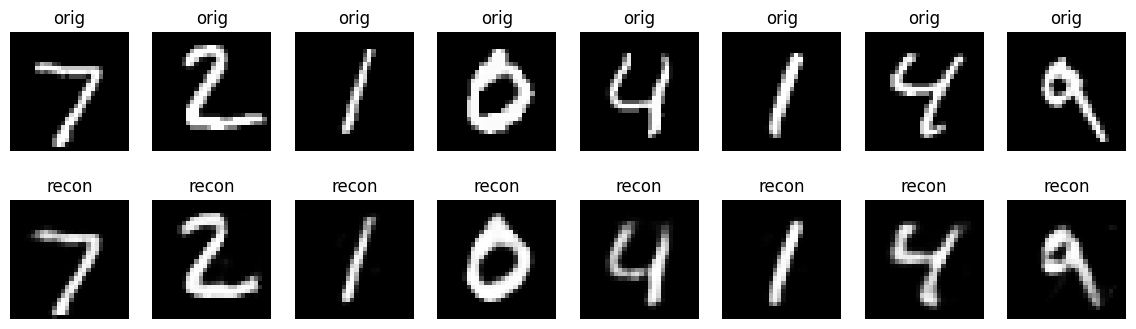

In [ ]:
def show_reconstructions(model, dataloader, device='cpu', num_images=8):
    model.to(device)
    model.eval()
    imgs, _ = next(iter(dataloader))
    imgs = imgs[:num_images].to(device)
    with torch.no_grad():
        flat = imgs.view(imgs.size(0), -1)
        recon = model(flat)
        recon_imgs = recon.view(-1, 1, 28, 28).cpu()

    imgs = imgs.cpu()
    # plot
    n = imgs.size(0)
    plt.figure(figsize=(n*1.8, 4))
    for i in range(n):
        # original
        plt.subplot(2, n, i+1)
        plt.axis('off')
        plt.title("orig")
        plt.imshow(imgs[i].squeeze(), cmap='gray')
        # recon
        plt.subplot(2, n, n + i + 1)
        plt.axis('off')
        plt.title("recon")
        plt.imshow(recon_imgs[i].squeeze(), cmap='gray')
    plt.show()


if __name__ == "__main__":
    #Hyperparams 
    BATCH_SIZE = 128
    EPOCHS = 12
    LR = 1e-3
    BOTTLENECK_DIM = 32   

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    
    model = Autoencoder(input_dim=28*28, bottleneck_dim=BOTTLENECK_DIM)
    print("Model created with bottleneck size =", BOTTLENECK_DIM)

    #Train step
    model = train_autoencoder(model, train_loader, epochs=EPOCHS, lr=LR, device=device, validate_loader=test_loader)

    # Visualization step
    show_reconstructions(model, test_loader, device=device, num_images=8)
